In [2]:
# uses conda environment gpflow6_0

# generic
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
import time

# plotting

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D 
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import gpflow as gpf
from gpflow.ci_utils import ci_niter, ci_range
from gpflow.utilities import print_summary

# tensorflow
import tensorflow as tf

#debug
from IPython.core.debugger import set_trace

from fen_functions import *

In [4]:
####################  Initialize parameters #######################

ice_model = "d6g_h6g_"
lith = 'l71C'
tmax = 8100
tmin = 7500
agemax = round(tmax, -3) + 100
agemin = round(tmin, -3) - 100
place = 'fennoscandia'
# ages_lgm = np.arange(100, 26000, 100)[::-1]
ages = np.arange(agemin, agemax, 100)[::-1]

locs = {'europe': [-20, 15, 35, 70],
        'fennoscandia': [-15, 50, 45, 75],
        'norway': [0, 50, 50, 75],
       }
extent = locs[place]

##Get Norway data sheet from Google Drive
sheet = 'Norway_isolation'
df_nor = load_nordata_fromsheet(sheet, fromsheet=True)

#import khan dataset
path = '../data/GSL_LGM_120519_.csv'
df_place = import_rsls(path, df_nor, tmin, tmax, extent)

# add zeros at present-day.  
# nout = 50
# df_place = add_presday_0s(df_place, nout)

####################  Make xarray template  #######################

filename = '../data/WAISreadvance_VM5_6ka_1step.mat'
ds_template = xarray_template(filename, ages, extent)

####################    Load GIA datasets   #######################

ds = make_mod(ice_model, lith, ages, extent)

#make mean of runs
ds_giamean = ds.mean(dim='modelrun').load().chunk((-1,-1,-1)).interp(lon=ds_template.lon, lat=ds_template.lat).to_dataset()
ds_giastd = ds.std(dim='modelrun').load().chunk((-1,-1,-1)).interp(lon=ds_template.lon, lat=ds_template.lat).to_dataset()
    
df_place['rsl_giaprior'] = df_place.apply(lambda row: ds_select(ds_giamean, row), axis=1)
df_place['rsl_giaprior_std'] = df_place.apply(lambda row: ds_select(ds_giastd, row), axis=1)
df_place['rsl_realresid'] = df_place.rsl - df_place.rsl_giaprior

print('number of datapoints = ', df_place.shape)

number of datapoints =  (178, 13)


In [33]:
import gpflow
import gpflow as gpf
from gpflow.utilities import print_summary, positive
from gpflow.logdensities import multivariate_normal
from gpflow.kernels import Kernel
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import InputData, RegressionData, MeanAndVariance, GPModel
from gpflow.base import Parameter 
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.config import default_jitter, default_float
from gpflow.inducing_variables import InducingPoints


class GPR_new(GPModel, InternalDataTrainingLossMixin):
    r"""
    Gaussian Process Regression.
    This is a vanilla implementation of GP regression with a Gaussian
    likelihood.  Multiple columns of Y are treated independently.
    The log likelihood of this model is sometimes referred to as the 'log
    marginal likelihood', and is given by
    .. math::
       \log p(\mathbf y \,|\, \mathbf f) =
            \mathcal N(\mathbf{y} \,|\, 0, \mathbf{K} + \sigma_n \mathbf{I})
    """

    def __init__(
        self,
        data: RegressionData,
        kernel: Kernel,
        mean_function: Optional[MeanFunction] = None,
        noise_variance: list = [],
    ):
        
        likelihood = gpflow.likelihoods.Gaussian(noise_variance)
        _, Y_data = data
        super().__init__(kernel, likelihood, mean_function, num_latent_gps=Y_data.shape[-1])
        self.data = data

    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return self.log_marginal_likelihood()

    def log_marginal_likelihood(self) -> tf.Tensor:
        r"""
        Computes the log marginal likelihood.
        .. math::
            \log p(Y | \theta).
        """
        X, Y = self.data
        K = self.kernel(X)
        num_data = X.shape[0]
        k_diag = tf.linalg.diag_part(K)
        s_diag = tf.convert_to_tensor(self.likelihood.variance)
        
        ks = tf.linalg.set_diag(K, k_diag + s_diag)
        L = tf.linalg.cholesky(ks)
        m = self.mean_function(X)

        # [R,] log-likelihoods for each independent dimension of Y
        log_prob = multivariate_normal(Y, m, L)
        return tf.reduce_sum(log_prob)

    def predict_f(
        self, Xnew: InputData, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        r"""
        This method computes predictions at X \in R^{N \x D} input points
        .. math::
            p(F* | Y)
        where F* are points on the GP at new data points, Y are noisy observations at training data points.
        """
        X_data, Y_data = self.data
#         Xnew_mu = X_data  # [N, D], hypothetically
#         Xnew_var = tf.linalg.diag(X_err) # [N, n, n], hypothetically
#         inducing_variable = InducingPoints(Xnew) # [M, D], hypothetically 
#         q_mu = Xnew
#         q_sqrt = tf.linalg.cholesky(self.kernel(Xnew))
        
        err = Y_data - self.mean_function(X_data)

        kmm = self.kernel(X_data)
        knn = self.kernel(Xnew, full_cov=full_cov)
        kmn = self.kernel(X_data, Xnew)

        num_data = X_data.shape[0]

        s = tf.linalg.diag(tf.convert_to_tensor(self.likelihood.variance))
        
        conditional = gpflow.conditionals.base_conditional
        f_mean_zero, f_var = conditional(
            kmn, kmm + s, knn, err, full_cov=full_cov, white=False)  # [N, P], [N, P] or [P, N, N]
        f_mean = f_mean_zero + self.mean_function(Xnew)
        return f_mean, f_var

In [51]:
table.head()

Column heading A. Identifier/original citation  \
0                                 #                               1   
1                    Column heading                Unique sample ID   
2  Data, interpretation, or comment                            Data   
3                             Units                     Contributor   
4                 store trosevatnet                             RCC   

        Unnamed: 2 B. Fields related to geographic location      Unnamed: 4  \
0                2                                        3               4   
1        Reference      Region code 1=russia 2=fennoscandia      Sub-region   
2             Data                           Interpretation  Interpretation   
3              NaN                                      NaN             NaN   
4  Lid et al. 2020                                        2        skanland   

  Unnamed: 5 Unnamed: 6    C. Fields related to horizontal position of RSL  \
0          5          6                                                  7   
1   Latitude  Longitude  Dating method 1=14C 2=Useries 3=OSL 4=ARR 6=te...   
2       Data       Data                                               Data   
3    degrees    degrees                                                NaN   
4      68.58      16.69                                               1.00   

      Unnamed: 8                 Unnamed: 9  ...  \
0              8                          9  ...   
1  Corrected age  Corrected age uncertainty  ...   
2           Data                       Data  ...   
3       14C a BP                      14C a  ...   
4            NaN                        NaN  ...   

  D.7 Fields use to calculate the past position and uncertainty of RSL from each sample  \
0                                                 68                                      
1                                                RSL                                      
2                                     Interpretation                                      
3                                                  m                                      
4                                            72.2888                                      

            Unnamed: 73           Unnamed: 74             Unnamed: 75  \
0                    69                    70                      71   
1  RSL 2σ Uncertainty +  RSL 2σ Uncertainty -  Corrected RSL (if any)   
2        Interpretation        Interpretation          Interpretation   
3                     m                     m                       m   
4            1.33050764            1.33050764                     NaN   

                            Unnamed: 76                           Unnamed: 77  \
0                                    72                                    73   
1  Corrected RSL uncertainty + (if any)  Corrected RSL uncertainty - (if any)   
2                        Interpretation                        Interpretation   
3                                     m                                     m   
4                                   NaN                                   NaN   

                Unnamed: 78 E. Additional notes    Unnamed: 80 Unnamed: 81  
0                        74                  75             76          77  
1  Correction type (if any)              Reject  Why rejected?       Notes  
2            Interpretation      Interpretation        Comment     Comment  
3                       NaN                 NaN            NaN         NaN  
4                       NaN                 NaN            NaN         NaN  

[5 rows x 82 columns]

In [54]:
len(table.iloc[1].values)

82

In [70]:
path = '../data/holocene_fennoscandian_data_05132020.csv'
table = pd.read_csv(path)

df.head()

index     Column heading Unique sample ID             Reference  \
0      4  store trosevatnet              RCC       Lid et al. 2020   
1      5        Svartvatnet              RCC       Lid et al. 2020   
2      6         Litjvatnet              RCC  ystgaard et al. 2019   
3      7         Litjvatnet              RCC  ystgaard et al. 2019   
4      8         Storvatnet              RCC  ystgaard et al. 2019   

  Region code 1=russia 2=fennoscandia Sub-region Latitude Longitude  \
0                                   2   skanland    68.58     16.69   
1                                   2   skanland    68.52     16.72   
2                                   2    Agdenes    63.58      9.63   
3                                   2    Agdenes    63.58      9.63   
4                                   2    Agdenes    63.60      9.63   

  Dating method 1=14C 2=Useries 3=OSL 4=ARR 6=tephra 7=varves 8=archaeo  \
0                                               1.00                      
1                                               1.00                      
2                                               1.00                      
3                                               1.00                      
4                                               1.00                      

  Corrected age  ...      RSL RSL 2σ Uncertainty + RSL 2σ Uncertainty -  \
0           NaN  ...  72.2888           1.33050764           1.33050764   
1           NaN  ...  37.7157          1.300074729          1.300074729   
2           NaN  ...   3.7263         0.2598646569         0.2598646569   
3           NaN  ...   3.7263         0.2598646569         0.2598646569   
4           NaN  ...   4.7287         0.2597308026         0.2597308026   

  Corrected RSL (if any) Corrected RSL uncertainty + (if any)  \
0                    NaN                                  NaN   
1                    NaN                                  NaN   
2                    NaN                                  NaN   
3                    NaN                                  NaN   
4                    NaN                                  NaN   

  Corrected RSL uncertainty - (if any) Correction type (if any) Reject  \
0                                  NaN                      NaN    NaN   
1                                  NaN                      NaN    NaN   
2                                  NaN                      NaN    NaN   
3                                  NaN                      NaN    NaN   
4                                  NaN                      NaN    NaN   

  Why rejected? Notes  
0           NaN   NaN  
1           NaN   NaN  
2           NaN   NaN  
3           NaN   NaN  
4           NaN   NaN  

[5 rows x 83 columns]

In [72]:
##Convert table data into a dataframe
df = table[4:].rename(columns=table.iloc[1]).reset_index()
df = df[['Column heading',
         'Latitude', 
         'Longitude', 
         'Type', 
         'RSL', 
         'RSL 2σ Uncertainty +',
         'RSL 2σ Uncertainty -',
        'Age',
        'Age 2 sigma uncertainty +',
        'Age 2 sigma uncertainty -',]].replace('', value=np.nan).dropna(how='any')
df_nor = df[df.Type == '0'].drop(['Type', 'Column heading'], axis=1).replace('%','',regex=True).astype('float')
df_nor.rename(columns={'Column heading':'lakename',
                       'Latitude':'lat',
                       'Longitude':'lon',
                       'RSL':'rsl',
                       'RSL 2σ Uncertainty +':'rsl_er_max',
                       'RSL 2σ Uncertainty -':'rsl_er_min',
                       'Age':'age',
                       'Age 2 sigma uncertainty +':'age_er_max',
                       'Age 2 sigma uncertainty -':'age_er_min'
                      }, inplace=True
             )

df_nor['rsl_er'] = (df_nor.rsl_er_max + df_nor.rsl_er_min)/2
df_nor['age_er'] = (df_nor.age_er_max + df_nor.age_er_min)/2
df_nor

lat    lon      rsl  rsl_er_max  rsl_er_min      age  age_er_max  \
1    68.52  16.72  37.7157    1.300075    1.300075   9315.0       100.0   
2    63.58   9.63   3.7263    0.259865    0.259865   1340.0        50.0   
3    63.58   9.63   3.7263    0.259865    0.259865   1670.0       110.0   
4    63.60   9.63   4.7287    0.259731    0.259731   1660.0       100.0   
5    63.74   9.84   8.8235    0.257435    0.257435   2110.0       110.0   
..     ...    ...      ...         ...         ...      ...         ...   
433  59.48   5.73  53.8447    2.029888    2.029888  11419.5       736.5   
434  59.39   5.65  37.5615    2.029948    2.029948  12339.5       401.5   
435  59.39   5.65  37.5973    2.029918    2.029918  10920.5       284.5   
437  70.07  28.88  32.3706    2.034454    2.034454   9860.0       384.0   
438  70.06  28.95  23.2912    2.032518    2.032518   6831.5        18.5   

     age_er_min    rsl_er  age_er  
1         100.0  1.300075   100.0  
2          50.0  0.259865    50.0  
3         140.0  0.259865   125.0  
4          70.0  0.259731    85.0  
5         190.0  0.257435   150.0  
..          ...       ...     ...  
433       736.5  2.029888   736.5  
434       401.5  2.029948   401.5  
435       284.5  2.029918   284.5  
437       384.0  2.034454   384.0  
438        18.5  2.032518    18.5  

[313 rows x 10 columns]

In [6]:
def grad2err(xyt, X, mean):
    """Convert Xerr at RSL points via gradient to Yerror following Mchutchon et al. 2011.""" 

    indices = np.where(np.in1d(np.round(xyt.flatten(), 2), X.flatten()))[0]
    Xgrad = np.diff(mean.numpy(), axis=0)[indices].flatten()

    X_nigp = tf.convert_to_tensor(np.diag(np.diag(Xgrad) @ X_errdiag @ np.diag(Xgrad).T))
    return X_nigp

In [7]:
def makexyt(ds_giamean, nout, ages):
    
    lat = np.linspace(min(ds_giamean.lat), max(ds_giamean.lat), nout)
    lon = np.linspace(min(ds_giamean.lon), max(ds_giamean.lon), nout)
    
    xyt = np.array(list(product(lon, lat, ages)))
    return(lat, lon, xyt)

In [ ]:
# lonlat = df_place[['lon', 'lat']]
# # agecomp = np.sort([np.append(ages, df_place.age)])[0, :]
# agetile = np.tile(ages, len(df_place))
# xyt_it = np.column_stack([lonlat.loc[lonlat.index.repeat(len(ages))], agetile])
# xyt_it = np.stack([xyt_it, X])

I need the gradient at each lat/lont/time point.  I don't need the entire time-series for each point, which would be 40*40*300.  I just need 3 points at each lat/lon location: one age plus two more on each side. That's xyt_it.  Then I need to predict_f at each xyt_it point and get the gradient at each point in xyt_it that is X.  

In [ ]:
# #Sandwich age of each lat/lon to enable gradient calculation
# lonlat = df_place[['lon', 'lat']]
# indices = np.arange(1, len(df_place)*3, 3)

# agetile = np.stack([df_place.age - 500, df_place.age, df_place.age + 500], axis=-1).flatten()
# xyt_it = np.column_stack([lonlat.loc[lonlat.index.repeat(3)], agetile])

# mean, _ = m.predict_f(xyt_it)

# Xgrad = np.diag(np.gradient(mean.numpy(), axis=0)[indices][:,0])

# X_nigp = np.diag(Xgrad @ np.diag(df_place.age_er**2) @ Xgrad.T)
# X_nigp = tf.convert_to_tensor(X_nigp)

# m.likelihood.variance = m.likelihood.variance + X_nigp


In [ ]:
# latlon = df_place[['lon', 'lat']]
# agetile = np.tile(ages, (len(df_place)))
# xyt_it = np.column_stack([latlon.loc[latlon.index.repeat(len(ages))], agetile])

In [13]:
########### Run GPR ######################

def run_gpr(k1len, k2len, k3len, k4len, df_place):
    print(k1len, k2len, k3len, k4len)
    # Input space, rsl normalized to zero mean, unit variance
    X = np.stack((df_place.lon, df_place.lat, df_place.age), 1)

    RSL = normalize(df_place.rsl_realresid)
    
    #define kernels  with bounds
    k1 = HaversineKernel_Matern32(active_dims=[0, 1], lengthscales=1)
    k1.lengthscales = bounded_parameter(100, 10000, k1len)  #hemispheric space
    # k1.lengthscales = bounded_parameter(1, 100, 3)  #hemispheric space
    k1.variance = bounded_parameter(0.02, 100, 2)

    k2 = gpf.kernels.Matern32(active_dims=[2], lengthscales=1)  #GIA time
    k2.lengthscales = bounded_parameter(1, 100000, k2len)
    k2.variance = bounded_parameter(0.02, 100, 1)

    k3 = HaversineKernel_Matern32(active_dims=[0, 1], lengthscales=1)
    k3.lengthscales = bounded_parameter(1, 10000, k3len)  #GIA space
    k3.variance = bounded_parameter(0.02, 100, 2)

    k4 = gpf.kernels.Matern32(active_dims=[2], lengthscales=1)  #shorter time
    k4.lengthscales = bounded_parameter(1, 10000, k4len)
    k4.variance = bounded_parameter(0.02, 100, 1)

    k5 = gpf.kernels.White(active_dims=[2])
    k5.variance = bounded_parameter(0.01, 100, 1)

    kernel = (k1 * k2) + (k3 * k4) + k5 

    ##################	  BUILD AND TRAIN MODELS 	#######################
    noise_variance = (df_place.rsl_er.ravel()/2)**2 + df_place.rsl_giaprior_std.ravel()**2  

    m = GPR_new((X, RSL), kernel=kernel, noise_variance=noise_variance) 
    
    #Sandwich age of each lat/lon to enable gradient calculation
    lonlat = df_place[['lon', 'lat']]
    agetile = np.stack([df_place.age - 10, df_place.age, df_place.age + 10], axis=-1).flatten()
    xyt_it = np.column_stack([lonlat.loc[lonlat.index.repeat(3)], agetile])

    #hardcode indices for speed (softcoded alternative commented out)
    indices = np.arange(1, len(df_place)*3, 3)
    # indices = np.where(np.in1d(df_place.age, agetile))[0]
    
    iterations = ci_niter(3000)
    learning_rate = 0.05
    logging_freq = 100
    opt = tf.optimizers.Adam(learning_rate)

    #first optimize without age errs to get slope
    tf.print('___First optimization___')
    likelihood = -10000
    for i in range(iterations):
        opt.minimize(m.training_loss, var_list=m.trainable_variables)

        likelihood_new = m.log_marginal_likelihood()
        if i % logging_freq == 0:
            tf.print(f"iteration {i + 1} likelihood {m.log_marginal_likelihood():.04f}")
            if abs(likelihood_new - likelihood) < 0.01:
                break
            likelihood = likelihood_new

    # Calculate posterior at training points + adjacent age points
    mean, _ = m.predict_f(xyt_it)

    # make diagonal matrix of age slope at training points
    Xgrad = np.diag(np.gradient(mean.numpy(), axis=0)[indices][:,0])

    # multipy age errors by gradient 
    Xnigp = np.diag(Xgrad @ np.diag(df_place.age_er**2) @ Xgrad.T)    
    
    m = GPR_new((X, RSL), kernel=kernel, noise_variance=noise_variance + Xnigp)

    #reoptimize
    tf.print('___Second optimization___')
    opt = tf.optimizers.Adam(learning_rate)
    
    likelihood=1
    for i in range(iterations):
        opt.minimize(m.training_loss, var_list=m.trainable_variables)
        
        likelihood_new = m.log_marginal_likelihood()
        if i % logging_freq == 0:
            tf.print(f"iteration {i + 1} likelihood {m.log_marginal_likelihood():.04f}")
            if i > 1:
                if abs(likelihood_new - likelihood) < 0.01:
                    lastlikelihood = (likelihood_new).numpy()
                    print(lastlikelihood)
                    break
                likelihood = likelihood_new
            
    ##################	  INTERPOLATE MODELS 	#######################
    ##################  --------------------	 ######################
    # output space
    
    nout = 40
    lat, lon, xyt = makexyt(ds_giamean, nout, ages)
    mean, da_zp, da_varp = gpr_predict_f(lat, lon, xyt, nout, ds_giamean, m, ages, df_place)

    #interpolate all models onto GPR grid
    ds_giapriorinterp, ds_giapriorinterpstd  = interp_likegpr(ds_giamean, ds_giastd, da_zp)

    # add total prior RSL back into GPR
    ds_priorplusgpr = da_zp + ds_giapriorinterp
    ds_varp = da_varp.to_dataset(name='rsl')

    #Calculate data-model misfits & GPR vals at RSL data locations
    df_place['gpr_posterior'] = df_place.apply(lambda row: ds_select(ds_priorplusgpr, row), axis=1)
    df_place['gprpost_std'] = df_place.apply(lambda row: ds_select(ds_varp, row), axis=1)
    df_place['gpr_diff'] = df_place.apply(lambda row: row.rsl - row.gpr_posterior, axis=1)
    df_place['diffdiv'] = df_place.gpr_diff / df_place.rsl_er
    
    k1_l = m.kernel.kernels[0].kernels[0].lengthscales.numpy()
    k2_l = m.kernel.kernels[0].kernels[1].lengthscales.numpy()
    k3_l = m.kernel.kernels[1].kernels[0].lengthscales.numpy()
    k4_l = m.kernel.kernels[1].kernels[1].lengthscales.numpy()
    
    return mean, ds_giapriorinterp, da_zp, ds_priorplusgpr, ds_varp, m, df_place, k1_l, k2_l, k3_l, k4_l

k1 = 2500
k2 = 10000
k3 = 100
k4 = 6000

start = time.time()
mean, ds_giapriorinterp, da_zp, ds_priorplusgpr, ds_varp, m, df_place, k1_l, k2_l, k3_l, k4_l = run_gpr(k1, k2, k3, k4, df_place)
print(f'time = {time.time()-start}')

print_summary(m, fmt='notebook')

2500 10000 100 6000
___First optimization___
iteration 1 likelihood -360.4593
iteration 101 likelihood -212.4957
iteration 201 likelihood -139.6481
iteration 301 likelihood -86.4113
iteration 401 likelihood -46.0253
iteration 501 likelihood -22.4514
iteration 601 likelihood -0.3342
iteration 701 likelihood 0.0889
iteration 801 likelihood 0.2540
iteration 901 likelihood 0.3559
iteration 1001 likelihood 0.4262
iteration 1101 likelihood 0.4775
iteration 1201 likelihood 0.5166
iteration 1301 likelihood 0.5471
iteration 1401 likelihood 0.5715
iteration 1501 likelihood 0.5915
iteration 1601 likelihood 0.6080
iteration 1701 likelihood 0.6218
iteration 1801 likelihood 0.6336
iteration 1901 likelihood 0.6437
iteration 2001 likelihood 0.6524
0.01
___Second optimization___
iteration 1 likelihood -350.6422
iteration 101 likelihood -228.6638
iteration 201 likelihood -147.9151
iteration 301 likelihood -90.5904
iteration 401 likelihood -47.1652
iteration 501 likelihood -25.1011
iteration 601 likeliho

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2537: RuntimeWarning: divide by zero encountered in true_divide
  (grid[i + 1] - grid[i]))
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2537: RuntimeWarning: invalid value encountered in true_divide
  (grid[i + 1] - grid[i]))
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2514: RuntimeWarning: invalid value encountered in multiply
  weight *= np.where(ei == i, 1 - yi, yi)
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2515: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


time = 220.8310511112213


In [ ]:
# weighted least squares inversion
noise_variance = (df_place.rsl_er.ravel()/2)**2 + df_place.rsl_giaprior_std.ravel()**2  
X = np.stack((df_place['lon'], df_place['lat'], df_place['age']), 1)
RSL = normalize(df_place.rsl_realresid)

G = m.kernel(X)
print(G.shape)

W = tf.linalg.diag(1/noise_variance**2)
print(f'W = {W.shape}')

GMG = np.linalg.lstsq(tf.transpose(G) @ W @ G, tf.transpose(G) @ W, rcond=None)[0]
print(f'GMG = {GMG.shape}')

mest = GMG @ RSL
print(f'mest = {mest.shape}')

dpre = G @ mest

Cm = GMG @ np.diag(noise_variance**2) @ GMG.T

NN = G @ GMG
n = np.diag(NN)
plt.plot(n)

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


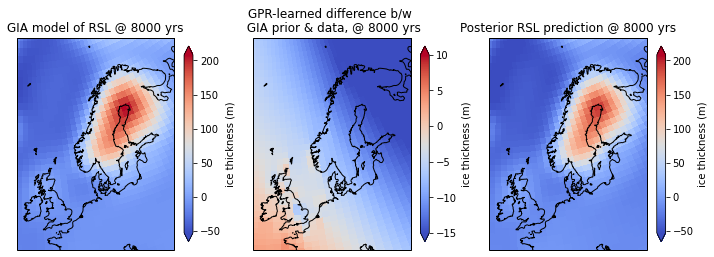

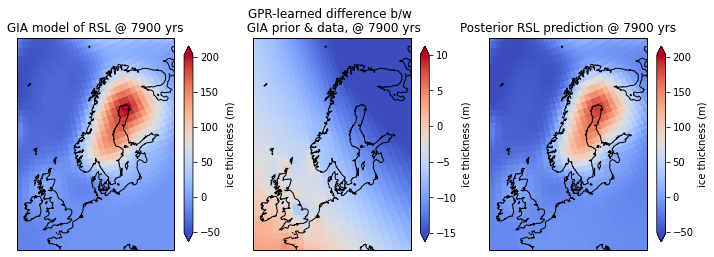

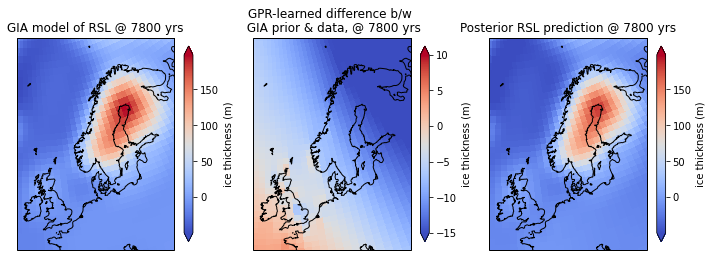

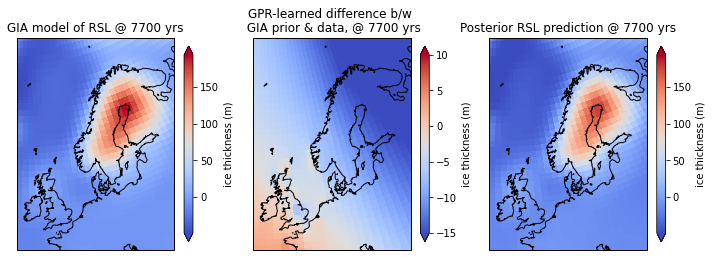

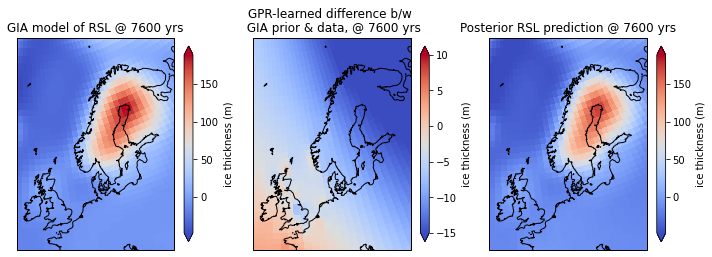

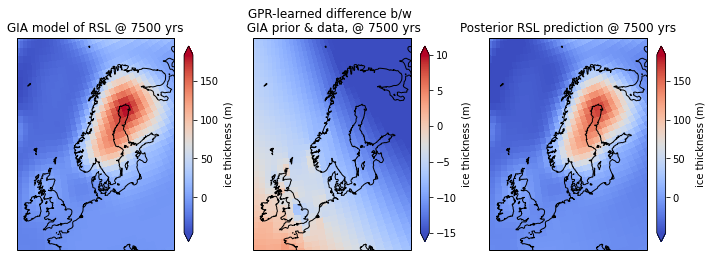

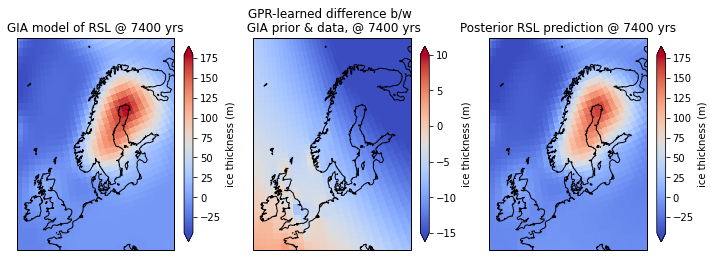

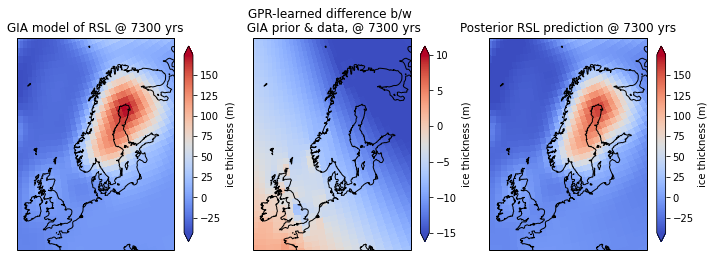

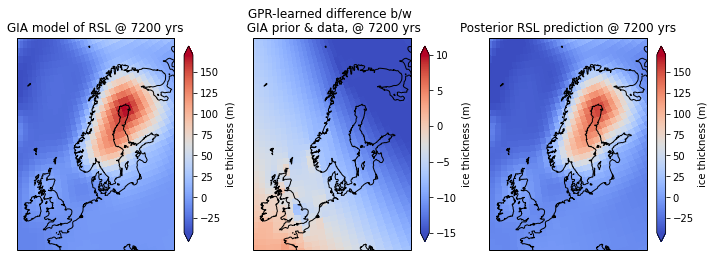

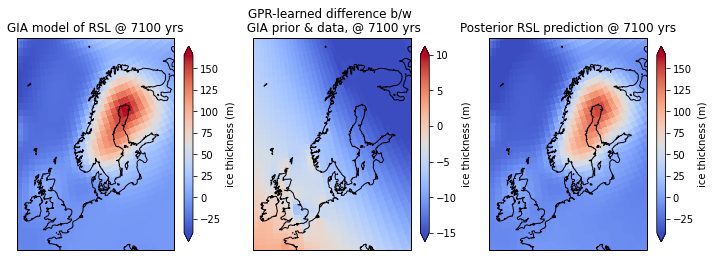

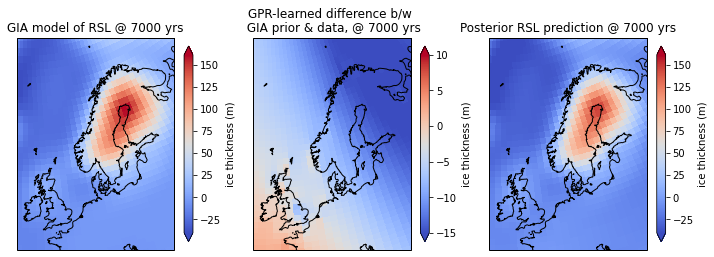

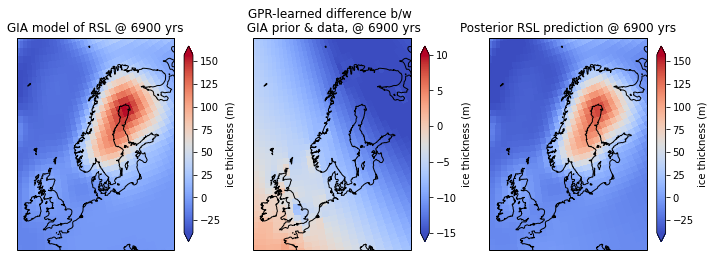

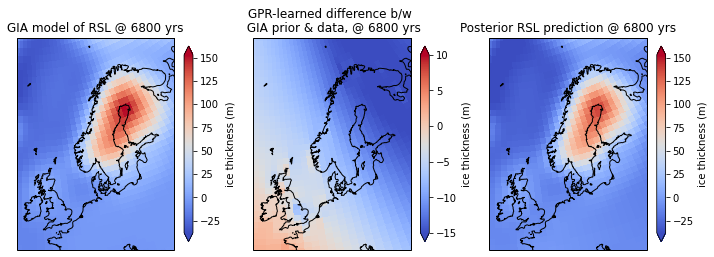

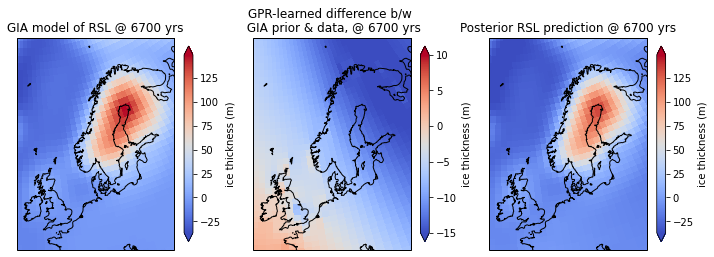

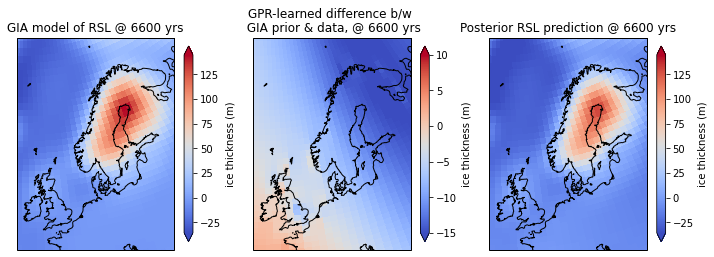

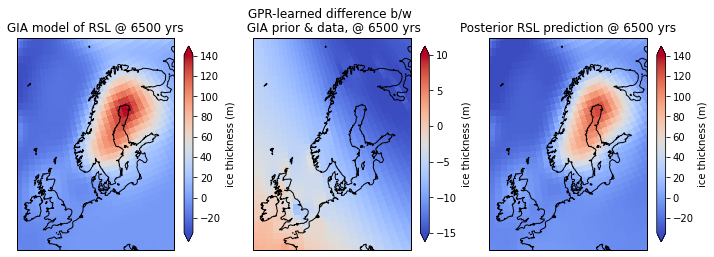

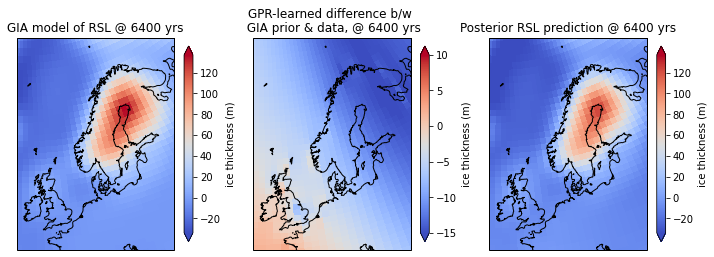

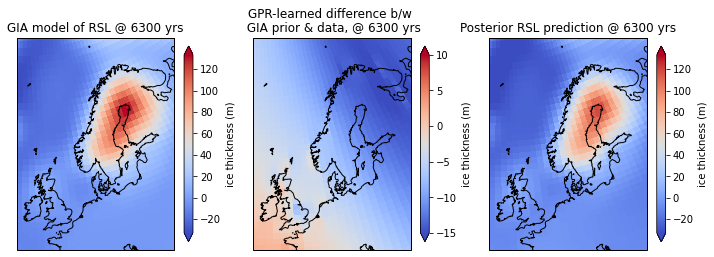

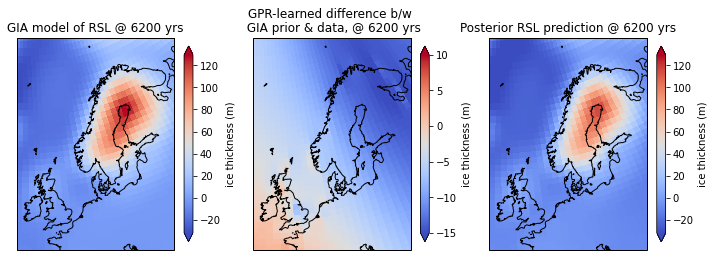

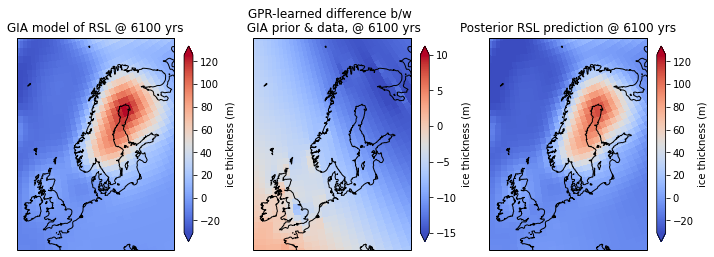

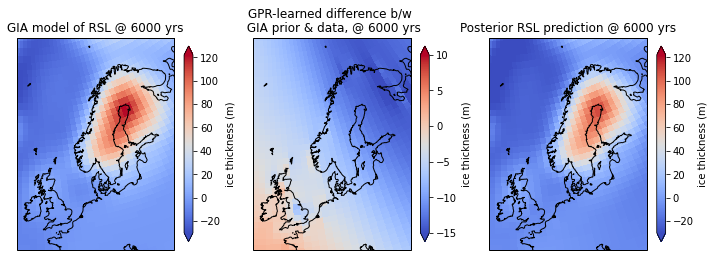

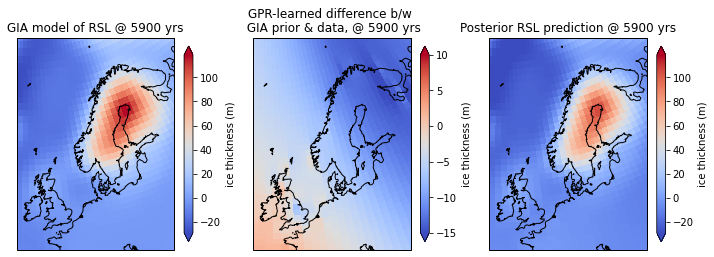

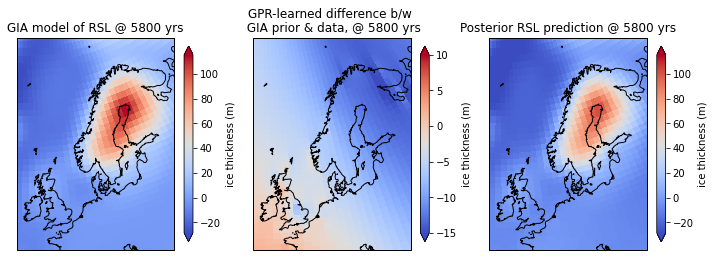

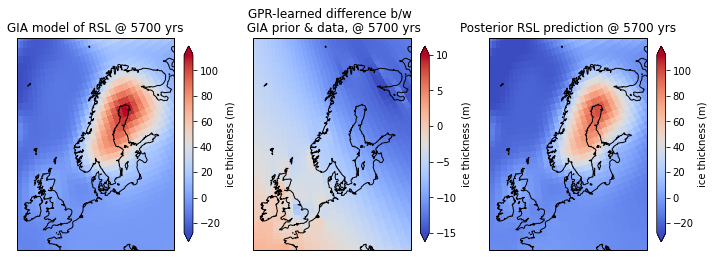

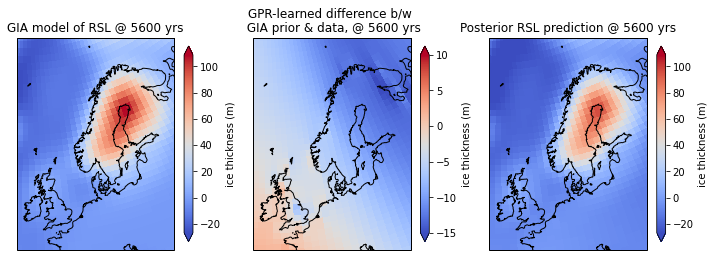

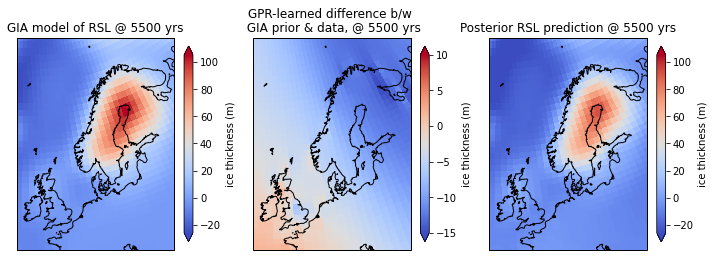

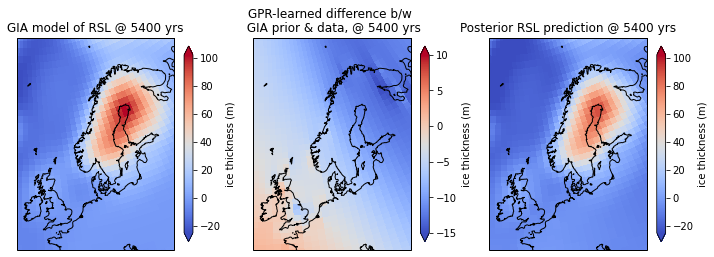

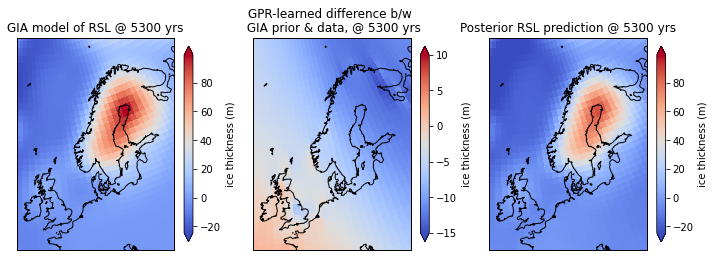

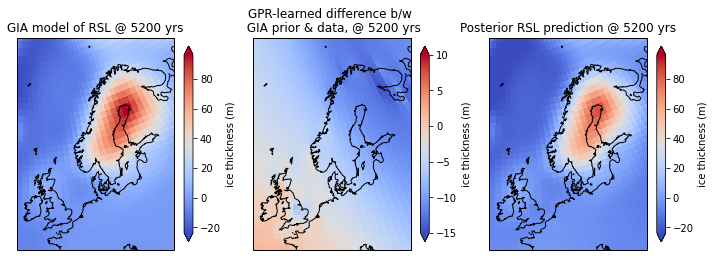

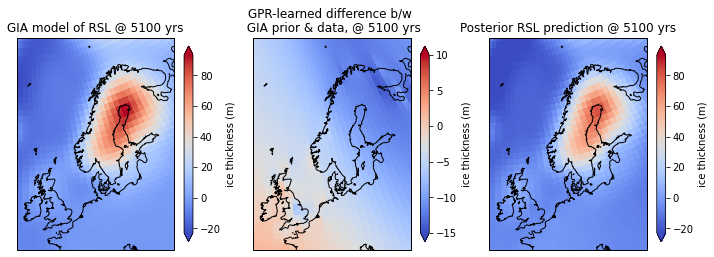

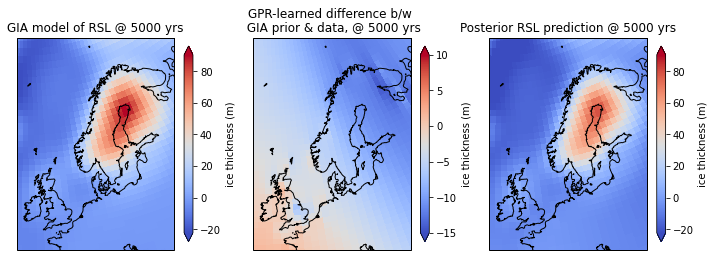

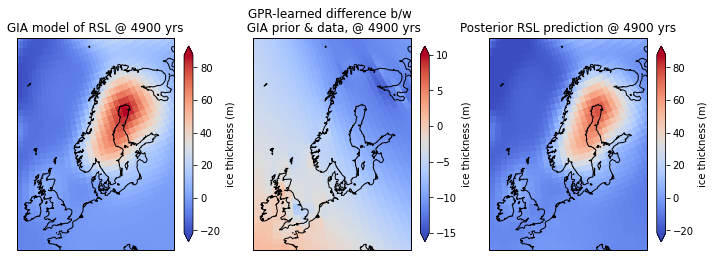

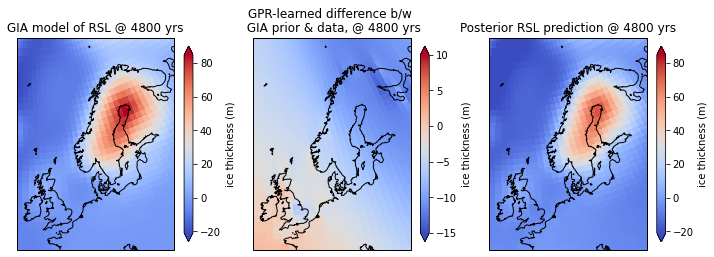

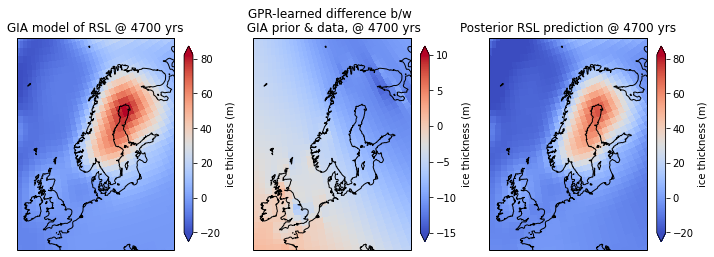

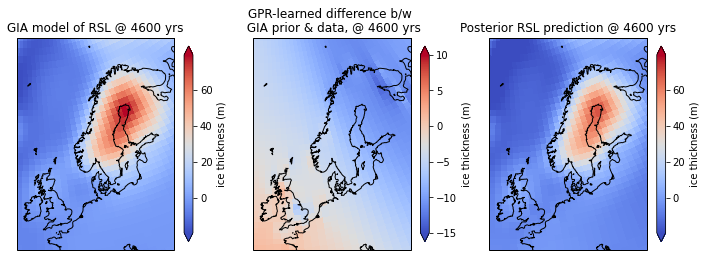

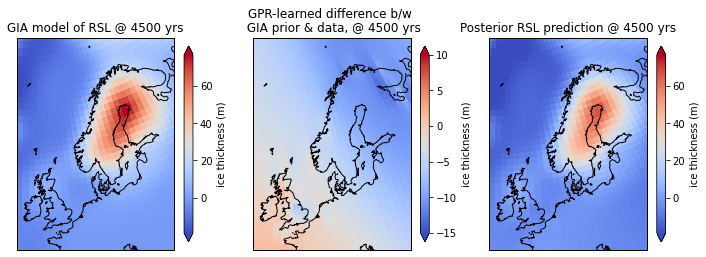

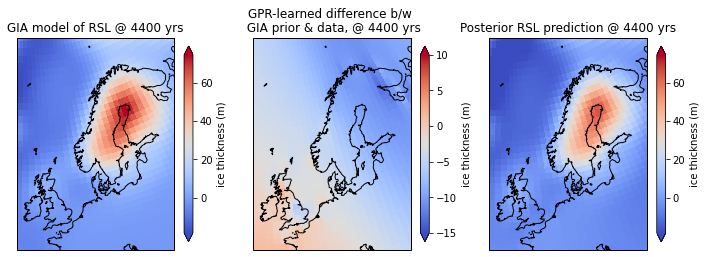

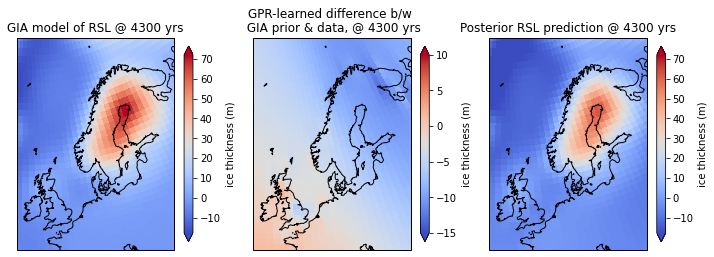

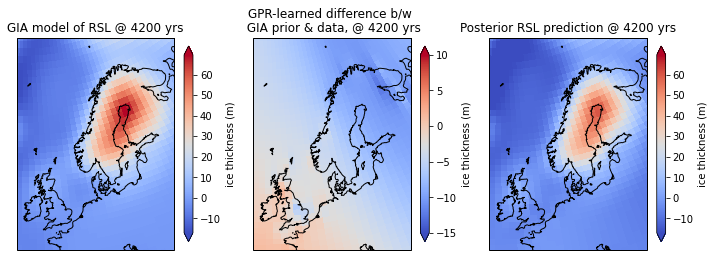

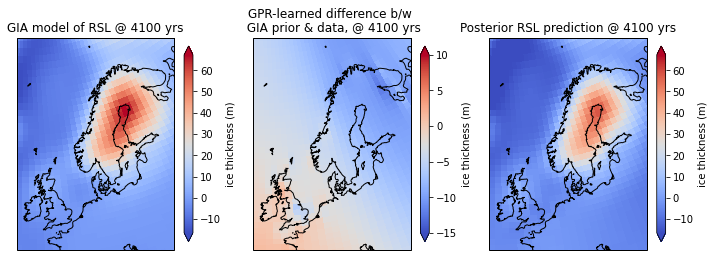

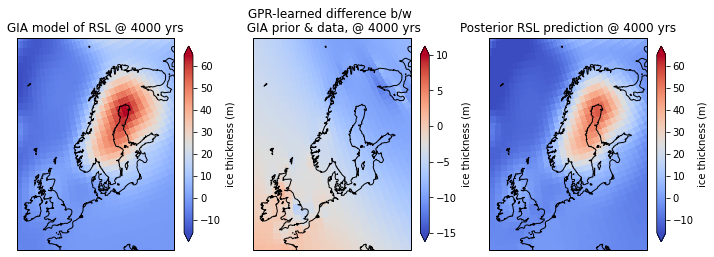

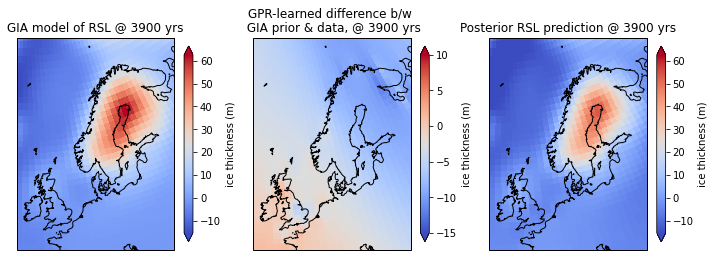

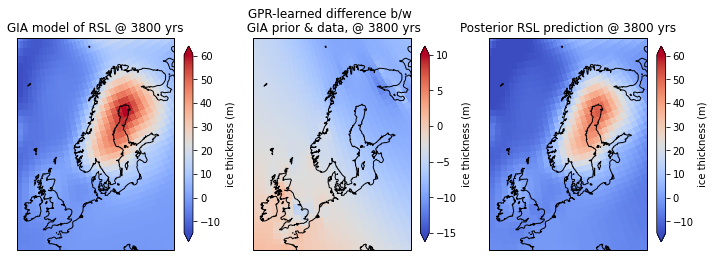

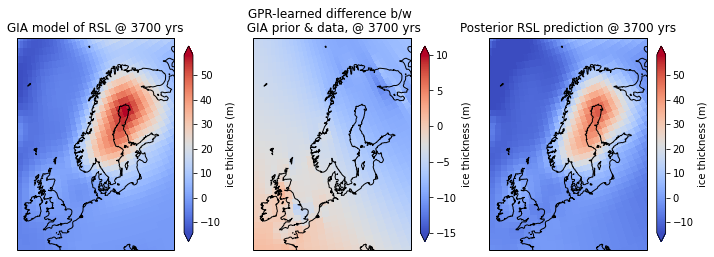

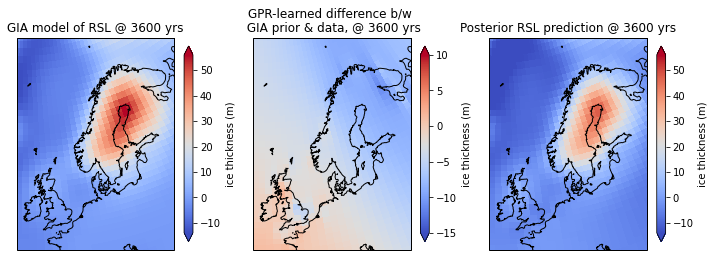

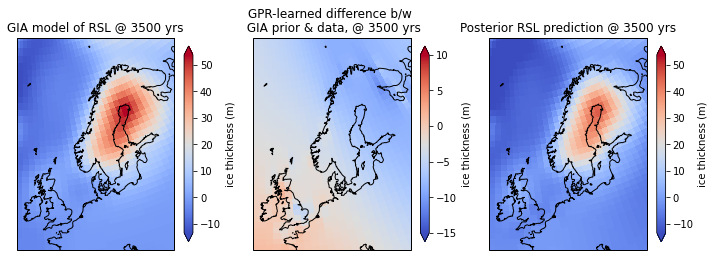

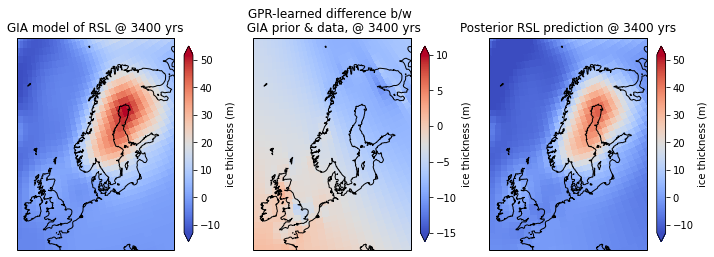

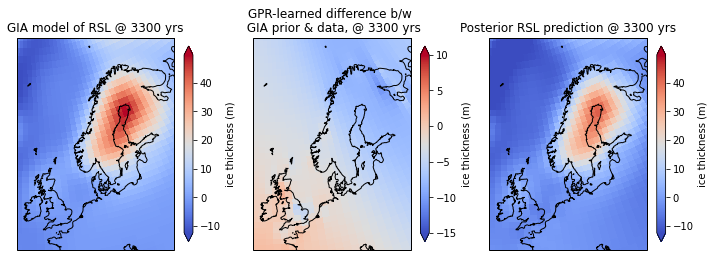

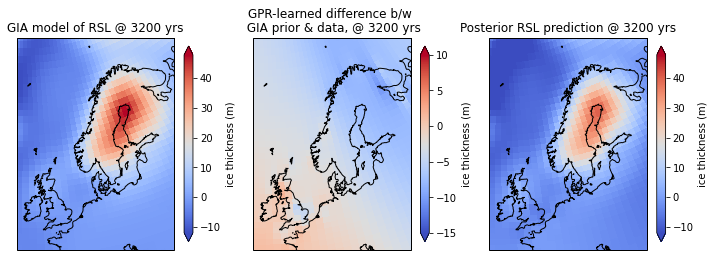

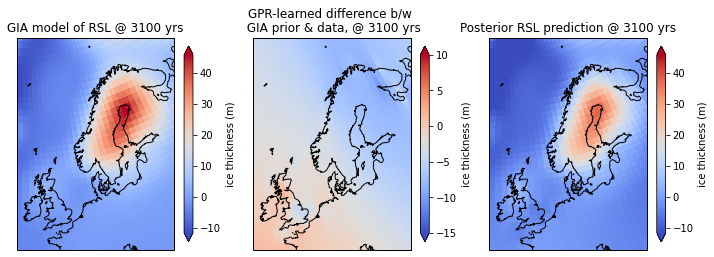

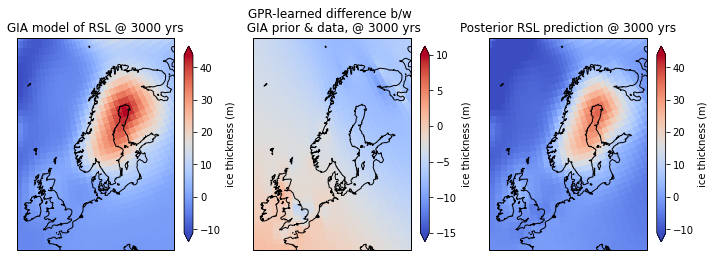

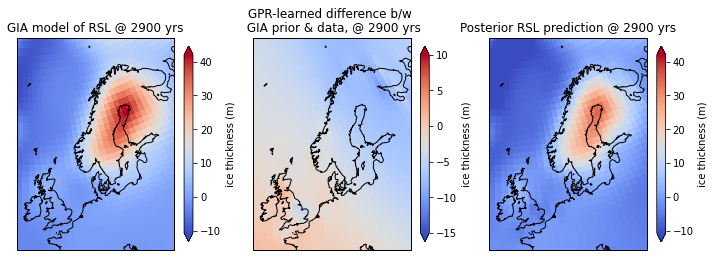

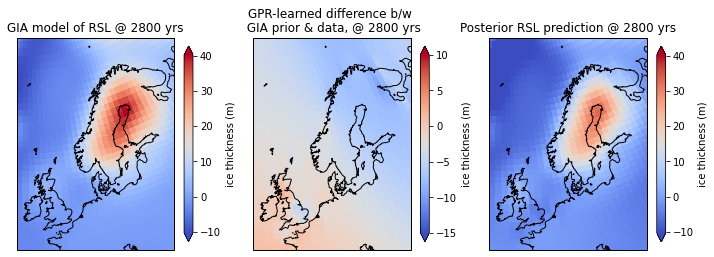

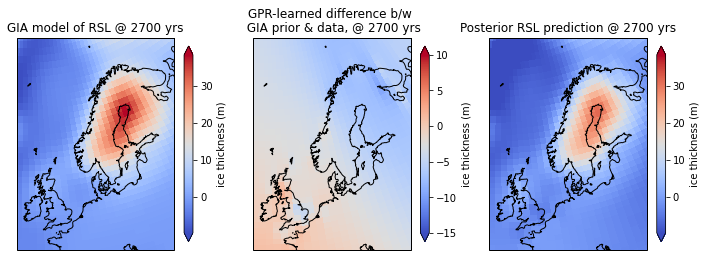

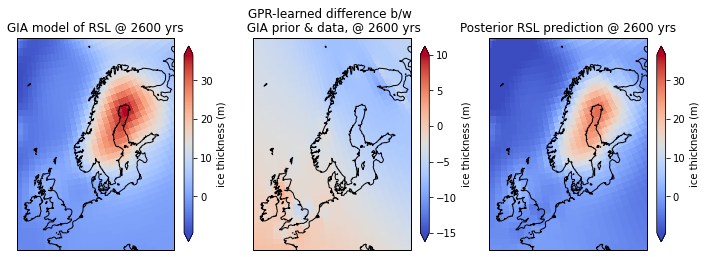

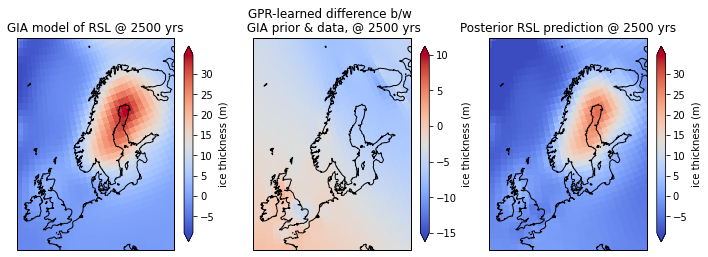

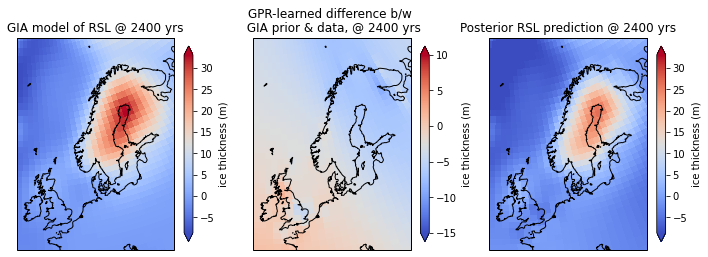

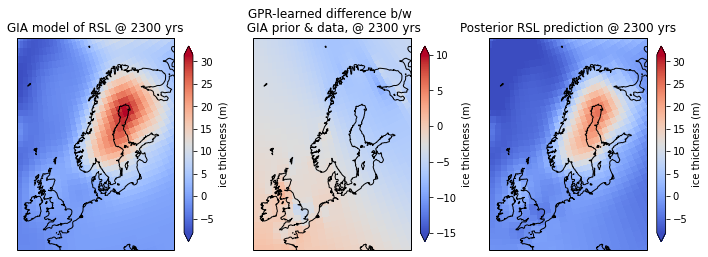

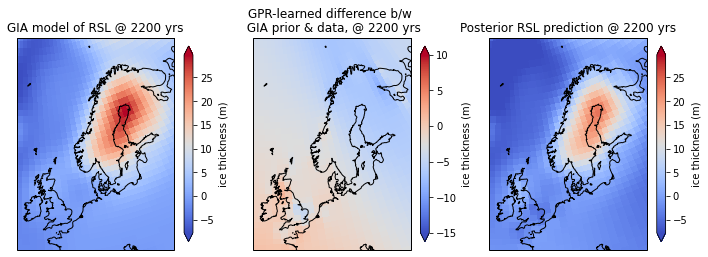

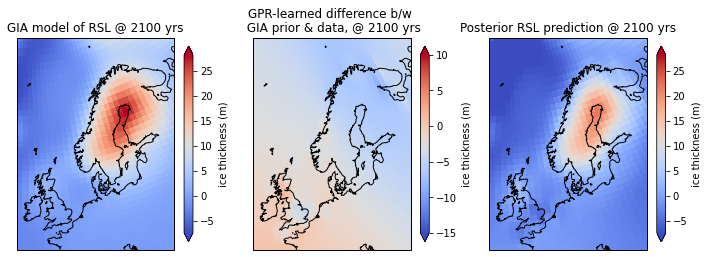

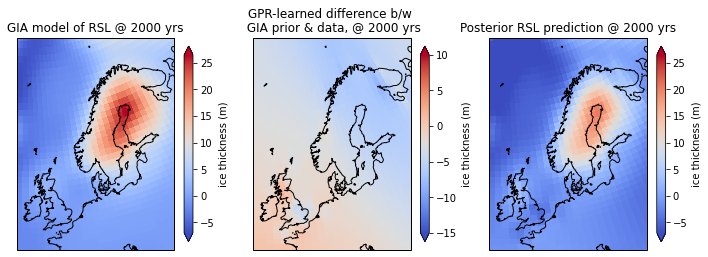

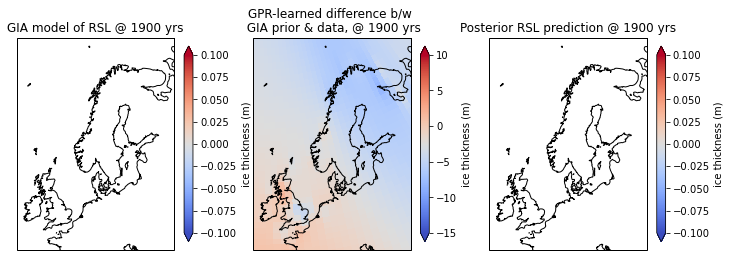

In [174]:
#visualize GPR-learned model and posterior
shrink = 0.3
extent = [-12, 25, 47, 75]

for i, age in enumerate(ages):
    fig, ax = plt.subplots(1, 3, figsize=(12, 12), subplot_kw=dict(projection=ccrs.LambertConformal(central_longitude=-10)))
    ax = ax.flatten()
    
    ax[0].coastlines(resolution='50m')
    ax[0].set_extent(extent)
    
    pc1 = ds_giapriorinterp.rsl.sel(age=age, 
                                    method='nearest').transpose().plot(ax=ax[0], 
                                                                       cmap='coolwarm', 
                      transform=ccrs.PlateCarree(),
                     add_colorbar=False,
                      extend='both',
                                                                      vmin=ds_giapriorinterp.rsl.sel(age=age,
                                                                                                     method='nearest').min(),
                                                                      vmax=ds_giapriorinterp.rsl.sel(age=age,
                                                                                                     method='nearest').max())
    cbar = fig.colorbar(pc1,ax=ax[0],shrink=shrink,label='ice thickness (m)', extend='both')
    ax[0].set_title(f'GIA model of RSL @ {age} yrs')
    
    
    ax[1].coastlines(resolution='50m')
    ax[1].set_extent(extent)
    
    pc1 = da_zp[i,:,:].plot(ax=ax[1], cmap='coolwarm', 
                      transform=ccrs.PlateCarree(),
                     add_colorbar=False,
                      extend='both', 
                           vmin=-15,
                           vmax=10)
    cbar = fig.colorbar(pc1,ax=ax[1],shrink=shrink,label='ice thickness (m)', extend='both')
    ax[1].set_title(f'GPR-learned difference b/w \n GIA prior & data, @ {age} yrs')


    pc2 = ds_priorplusgpr.rsl[i,:,:].plot(ax=ax[2], cmap='coolwarm', 
                                    transform=ccrs.PlateCarree(),
                                   add_colorbar=False,
                      extend='both',
                                         vmin=ds_giapriorinterp.rsl.sel(age=age,method='nearest').min(),
                                        vmax=ds_giapriorinterp.rsl.sel(age=age,method='nearest').max())
    ax[2].set_title(f'Posterior RSL prediction @ {age} yrs')
    
    cbar = fig.colorbar(pc2,ax=ax[2],shrink=shrink,label='ice thickness (m)', extend='both')
    ax[2].coastlines(resolution='50m')
    ax[2].set_extent(extent)

#     if i >= 6:
#         break

In [155]:
df_nor_ =df_nor[(df_nor.age < tmax) & 
               (df_nor.age > tmin) ]

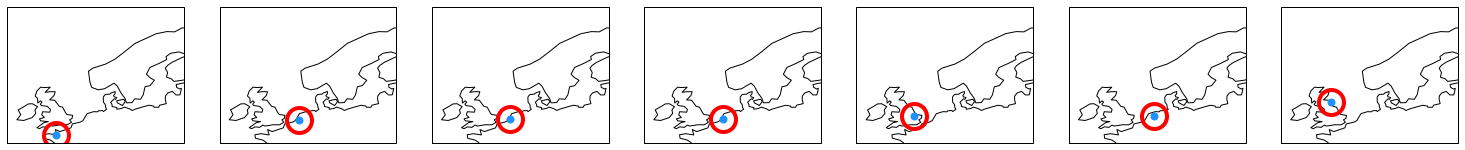

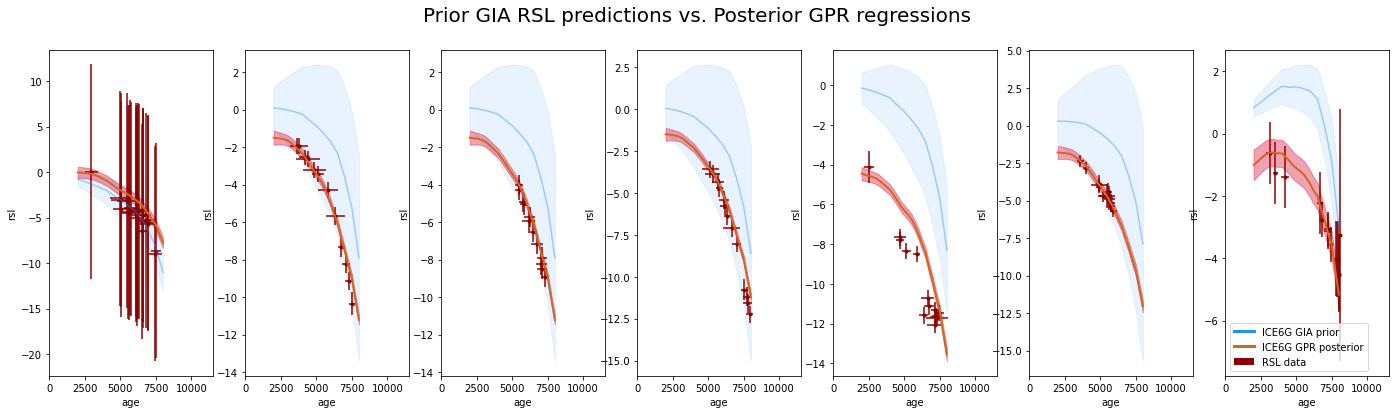

In [171]:
number=11

df_nufsamps = locs_with_enoughsamples(df_place, place, number)
nufsamp = df_nufsamps.locnum.unique()

def interp_ds(ds):
    return ds.interp(age=ds_giamean.age, lat=ds_giamean.lat, lon=ds_giamean.lon)

def slice_dataset(ds):
    return ds.rsl.sel(lat=site[1].lat.unique() ,
                  lon=site[1].lon.unique(),
                  method='nearest').sel(age=slice(11500, 0))


###### Plot  #####


fig, ax = plt.subplots(1,len(nufsamp), figsize=(26, 6), subplot_kw=dict(projection=proj))
ax = ax.ravel()

da_zeros = xr.zeros_like(ds_giamean.rsl[:,:,0])

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    ax[i].set_extent(extent)
    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=7,
               marker='o',
               transform=proj)
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=25,
               marker='o',
               transform=proj,
               mfc="None",
               mec='red',
               mew=4)
    da_zeros.plot(ax=ax[i], cmap='Greys', add_colorbar=False)
#     ax[i].set_title(site[0], fontsize=fontsize)
    ax[i].set_title('')
#     if i > 6:
#         break



proj = ccrs.PlateCarree()

colormark = ['dodgerblue', 'chocolate', 'darkred', 'crimson', 'olivedrab']
cmaps = cmap_codes('viridis', len(df_nufsamps))
    
num = 6
fig, ax = plt.subplots(1, len(nufsamp), figsize=(24, 6))
ax = ax.ravel()

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
    plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions", fontsize=20)

#     #slice data for each site
    prior_it = slice_dataset(ds_giamean) # [:,:,:-4]
    var_itprior = slice_dataset(ds_giastd)
    top_prior = prior_it + var_itprior * 2
    bottom_prior = prior_it - var_itprior * 2


    post_it = slice_dataset(ds_priorplusgpr)
    var_it = slice_dataset(np.sqrt(ds_varp))
    top = post_it + var_it * 2
    bottom = post_it - var_it * 2
    
    site_err = 2 * (site[1].rsl_er)
    age_err = 2 * site[1].age_er

    prior_it.plot(ax=ax[i], c=colormark[0], alpha=0.4, label='ICE6G GIA prior')
    ax[i].fill_between(prior_it.age, bottom_prior.squeeze(), top_prior.squeeze(), color=colormark[0], alpha=0.1) 


    post_it.plot(ax=ax[i], lw=2, c=colormark[1], alpha=1, label='ICE6G GPR posterior')
    ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colormark[3], alpha=0.4) 

    
    ax[i].scatter(site[1].age, site[1].rsl, c=colormark[2], s=4, lw=2,label='RSL data')
    ax[i].errorbar(site[1].age, site[1].rsl, yerr=site_err, xerr=age_err, c=colormark[2], fmt='none', capsize=-.1,lw=1.5)

    ax[i].set_xlim(0, 11500)
#     ax[i].set_ylim(-15,10)
    ax[i].set_title('')
#     if i > num:
#         break

lines = [ Line2D([0], [0], color=colormark[0], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=colormark[1], linewidth=3, linestyle='-'),
         Circle([0], 0.1, color=colormark[2], linewidth=3, ec="none")]

labels = ['ICE6G GIA prior', 'ICE6G GPR posterior', 'RSL data']
ax[i].legend(lines, labels, loc='lower left')


plt.show()

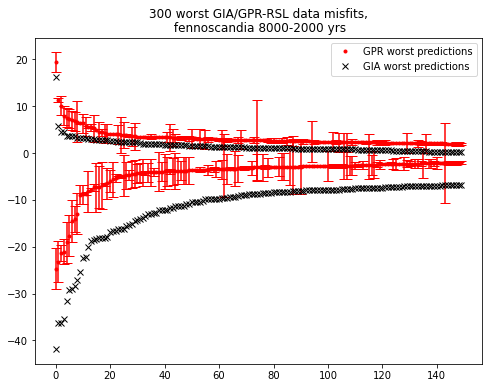

In [323]:
n=150
n_l = np.linspace(0, n-1, n)
# column = 'data_gpr_diff'
column = 'rsl_realresid'
worst_pos_gia = df_place.nlargest(n, columns=column)
worst_neg_gia = df_place.nsmallest(n, columns=column)


column = 'gpr_diff'
worst_pos_gpr = df_place.nlargest(n, columns=column)
worst_neg_gpr = df_place.nsmallest(n, columns=column)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(n_l, worst_pos_gpr.gpr_diff.values, 'r.', label='GPR worst predictions')
ax.errorbar(n_l, worst_pos_gpr.gpr_diff.values, 
            worst_pos_gpr.rsl_er.values, c='r', fmt='none', capsize=5,lw=1.5)


ax.plot(worst_neg_gpr.gpr_diff.values, 'r.')
ax.errorbar(n_l, worst_neg_gpr.gpr_diff.values, 
            worst_neg_gpr.rsl_er.values, c='r', fmt='none', capsize=5,lw=1.5)

ax.plot(worst_pos_gia.rsl_realresid.values, 'kx', label='GIA worst predictions')
ax.plot(worst_neg_gia.rsl_realresid.values, 'kx')
# ax.set_ylim(-10, 10)


plt.title(f'{n*2} worst GIA/GPR-RSL data misfits,\n {place} {tmax}-{tmin} yrs')
plt.legend();

In [119]:
# wors = worst_neg_gpr
# extent = [30, 45, 62, 72]
# df_place[(df_place.lon < extent[1]) &
#         (df_place.lon > extent[0]) &
#         (df_place.lat > extent[2]) &
#         (df_place.lat < extent[3]) ]

In [316]:
####################  Initialize parameters #######################
tmax = 8000
tmin = 2000
agemax = round(tmax, -3) + 100
agemin = round(tmin, -3) - 100
place = 'fennoscandia'
ages = np.arange(agemin, agemax, 100)[::-1]

locs = {'uk_northsea': [-15, 15, 45, 62],
        'fennoscandia': [-15, 50, 45, 75],
        'norway': [0, 50, 50, 75],
        'europe_arctic': [-15, 80, 45, 85]
       }
extent = locs[place]

##Get Norway data sheet from Google Drive
sheet = 'Norway_isolation'
df_nor = load_nordata_fromsheet(sheet)

#import khan dataset
path = 'data/GSL_LGM_120519_.csv'
df_all = import_rsls(path, df_nor, tmin, tmax, extent)
print('number of datapoints = ', df_all.shape)

number of datapoints =  (1525, 10)


In [268]:
# extent = [30, 45, 66, 70]
# worst_neg_gpr[(worst_neg_gpr.lon > extent[0]) &
#       (worst_neg_gpr.lon < extent[1]) &
#       (worst_neg_gpr.lat > extent[2]) &
#       (worst_neg_gpr.lat < extent[3]) ]

lat    lon   rsl  rsl_er_max  rsl_er_min     age  age_er_max  \
1677  66.70  34.33  36.0       4.393       4.393  8053.0       922.0   
1650  66.77  32.66  38.0       4.450       4.450  6797.0       443.0   
1665  69.48  30.16  29.5       1.761       1.761  7477.0       186.0   
1640  66.34  32.73  33.0       2.748       2.748  6353.0       279.0   
1659  66.78  34.27  30.0       4.393       4.393  7123.0       346.0   
1628  66.72  32.69  30.0       4.450       4.450  5753.0       427.0   
1642  66.30  32.78  40.0       2.748       2.748  6390.0       255.0   
1645  66.78  34.24  27.0       4.393       4.393  6500.0       393.0   
1592  66.54  33.14  27.5       5.225       5.225  5050.0       414.0   
1603  67.16  32.42  24.0       4.450       4.450  5241.0       930.0   
1671  69.20  33.37  31.0       4.965       4.965  7732.0       280.0   
1646  69.26  33.23  22.0       3.302       3.302  6602.0       350.0   

      age_er_min  rsl_er  age_er  rsl_giaprior  rsl_giaprior_std  \
1677       716.0   4.393   819.0     71.422839          7.448568   
1650       390.0   4.450   416.5     79.841299         11.678789   
1665       208.0   1.761   197.0     51.690718          6.272809   
1640       326.0   2.748   302.5     69.284027         10.798371   
1659       391.0   4.393   368.5     58.469014          7.021788   
1628       427.0   4.450   427.0     61.685244         10.538892   
1642       203.0   2.748   229.0     69.284027         10.798371   
1645       372.0   4.393   382.5     52.335413          6.689802   
1592       430.0   5.225   422.0     45.622238          8.626238   
1603       882.0   4.450   906.0     46.341127          8.967288   
1671       299.0   4.965   289.5     48.891197          5.045780   
1646       313.0   3.302   331.5     40.755105          4.637038   

      rsl_realresid  gpr_posterior  gprpost_std   gpr_diff    diffdiv  
1677     -35.422839      60.730861     0.115418 -24.730861  -5.629607  
1650     -41.841299      61.167004     0.070469 -23.167004  -5.206068  
1665     -22.190718      50.838416     0.114145 -21.338416 -12.117215  
1640     -36.284027      54.042608     0.069279 -21.042608  -7.657427  
1659     -28.469014      47.632568     0.083447 -17.632568  -4.013787  
1628     -31.685244      44.483509     0.068232 -14.483509  -3.254721  
1642     -29.284027      54.042608     0.069279 -14.042608  -5.110120  
1645     -25.335413      39.980771     0.067737 -12.980771  -2.954876  
1592     -18.122238      34.816858     0.069530  -7.316858  -1.400356  
1603     -22.341127      31.296225     0.029724  -7.296225  -1.639601  
1671     -17.891197      37.911768     0.048016  -6.911768  -1.392098  
1646     -18.755105      28.417799     0.049344  -6.417799  -1.943610

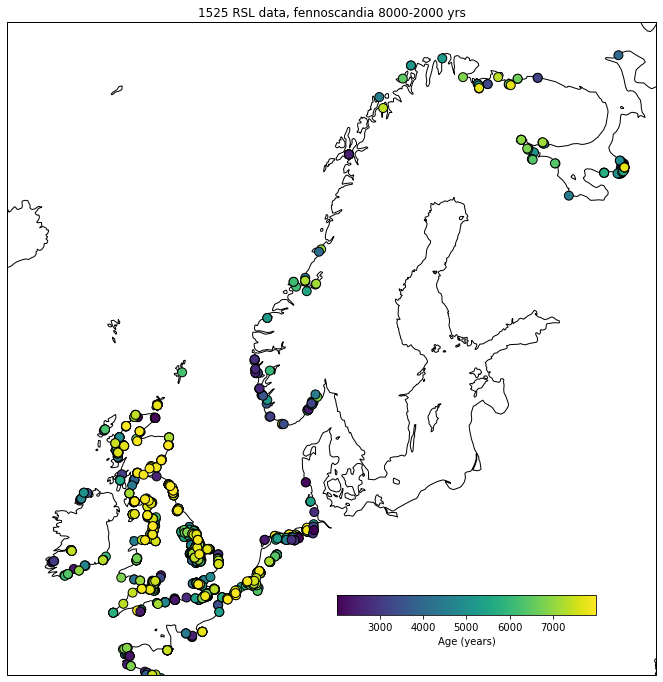

In [321]:

fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=ccrs.LambertConformal(central_longitude=0)))

ax.coastlines(resolution='50m')
# ax.set_extent([-10, 10, 45, 62])

ax.set_extent([-12, 30, 47, 72])
# ax.set_extent([-15, 10, 45, 62])
# ax.set_extent([5, 9, 53, 58])


scat = ax.scatter(df_all.lon, df_all.lat, s=80, c = df_all.age, 
                  cmap='viridis', edgecolor='k', linewidths=1, 
                  transform=ccrs.PlateCarree(), zorder=5)

cbaxes = inset_axes(ax, width="40%", height="3%", loc=4, borderpad=6,) 
cbar = fig.colorbar(scat, ax=ax, cax=cbaxes, shrink=.5,
                    label='Age (years)', 
                   orientation='horizontal')

ax.set_title(f'{len(df_all)} RSL data, {place} {tmax}-{tmin} yrs');

fig.savefig('/Users/rogercreel/Desktop/dataplot_fennoscandia')

# scat3 = ax.scatter(df_place.lon, df_place.lat, s=100, color='green', 
#                     edgecolor='k', linewidths=1, vmin=-20, vmax=0,
#                   transform=ccrs.PlateCarree(), zorder=3)

# ax.set_title(f'All datapoints, {place} {tmax}-{tmin} yrs')

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=ccrs.LambertConformal(central_longitude=-10)))

ax.coastlines(resolution='50m')
ax.set_extent([-12, 25, 47, 72])
# ax.set_extent([35, 40, 62, 70])


scat = ax.scatter(worst_pos_gpr.lon, worst_pos_gpr.lat, s=200, c = worst_pos_gpr.gpr_diff, 
                  cmap='Reds', edgecolor='k', linewidths=1, vmin=0, vmax=20,
                  transform=ccrs.PlateCarree(), zorder=5)

cbaxes = inset_axes(ax, width="40%", height="3%", loc=4, borderpad=7,) 
cbar = fig.colorbar(scat, ax=ax, cax=cbaxes, shrink=.7,
                    label='meters between RSL datum & GPR prediction \n *positive* ', 
                   orientation='horizontal')

scat2 = ax.scatter(worst_neg_gpr.lon, worst_neg_gpr.lat, s=200, c = worst_neg_gpr.gpr_diff, 
                  cmap='Blues_r', edgecolor='k', linewidths=1, vmin=-20, vmax=0,
                  transform=ccrs.PlateCarree(), zorder=4)

cbaxes = inset_axes(ax, width="40%", height="3%", loc=2, borderpad=2,) 
cbar = fig.colorbar(scat2, ax=ax, cax=cbaxes, shrink=.7,
                    label='meters between RSL datum & GPR prediction \n *negative* ', 
                   orientation='horizontal')

ax.set_title(f'{n*2} Largest RSL data v. GPR model misfits, {place} {tmax}-{tmin} yrs');

# scat3 = ax.scatter(df_place.lon, df_place.lat, s=100, color='green', 
#                     edgecolor='k', linewidths=1, vmin=-20, vmax=0,
#                   transform=ccrs.PlateCarree(), zorder=3)

# ax.set_title(f'All datapoints, {place} {tmax}-{tmin} yrs')

Start with small subset of data spread in space and time.  

1.  Try a bunch of lengthscales for 1 and 2 time/space kernels
    +what are maximum likelihoods for each?

2.  Calculate squared errors for all data/model sites and:
    1.  Map out sites with largest data/model misfit
        + Do large data/model misfit sites have other data around them?
        + is misfit positive or negative?
        + if sites are close together, does kernel with shorter wavelength fit it better? 

    2.  Dropping datapoints with largest errors
    3.  Adding uncertainty to datapoints with largest errors

Repeat this for another smaller subset of data


In [ ]:

#         lastlike = likelihood.numpy().round()
#         textlist.append([lastlike, len(bigerrs), ])
# results = pd.DataFrame(results, columns=['k1', 'k2', 'k3', 'k4', 'log marginal likelihood'])
# results

# scale1 = np.linspace(500, 5100, 4)
# scale2 = np.linspace(100, 10000, 4)
# scale3 = np.linspace(100, 6000, 4)
# scale4 = np.linspace(100, 6000, 4)

# results = [[k1, k2, k3, k4, run_gpr(k1, k2, k3, k4)] 
#            for k1 in scale1
#            for k2 in scale2
#            for k3 in scale3
#            for k4 in scale4]


In [ ]:
Xnew_mu = X
Xnew_var = tf.linalg.diag(((df_place.age_er)**2)[:,None])
print(f'Xnew_mu shape = {Xnew_mu.shape}')
print(f'Xnew_var shape = {Xnew_var.shape}')
q_mu = xyt
print(f'q_mu shape = {q_mu.shape}')

q_sqrt = tf.linalg.cholesky(m.kernel(xyt))
print(f'q_sqrt shape = {q_sqrt.shape} ')


X = np.stack((df_place['lon'], df_place['lat'], df_place['age']), 1)
print(f'X_data shape ={X.shape} = [M, D]')

RSL = normalize(df_place.rsl_realresid)
print(f'Y_data shape = {RSL.shape} = [M, R]')

nout = 10
lat = np.linspace(min(ds_giamean.lat), max(ds_giamean.lat), nout)
lon = np.linspace(min(ds_giamean.lon), max(ds_giamean.lon), nout)
xyt = np.array(list(product(lon, lat, ages)))


print('X_new shape =', xyt.shape, '= [N, D]')

# print(f'mean_out shape = {y_pred.shape} = [N, R]')
# print(f'variance_out shape = {y_var.shape} = [N, R]')

In [ ]:
Kmm = m.kernel(m.data[0])
print('kmm shape =',kmm.shape, '[M, M]')

Knn = m.kernel(xyt)
print('knn shape =',knn.shape, '[N, N]')

Kmn = m.kernel(m.data[0], xyt)
print('kmn shape =',kmn.shape, '[M, N]')


f = m.kernel(m.data[0]) - m.mean_function(m.data[1])
print('f shape =',f.shape, '[M, R]')
